In [2]:
!pip install colorama

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import csv
from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from colorama import init, Fore, Back, Style

plt.rcParams["figure.figsize"] = (10,10)



# Leer Dataframe 
### **(hay muchas areas con valor 0, afectará los resultados?)**

In [4]:
def ReadFile():
    dataset = pd.read_csv('./forestfires.csv', header=0)
    return dataset
dataset = ReadFile()

## Convertir dia y mes a INT



In [5]:
from calendar import month_abbr, day_abbr

month_mapping = [m.lower() for m in month_abbr]
day_mapping = [d.lower() for d in day_abbr]

dataset['month'] = dataset['month'].str.lower().map(lambda m: month_mapping.index(m)).astype('Int8') 
dataset['day'] = dataset['day'].str.lower().map(lambda d: day_mapping.index(d)).astype('Int8')

dataset.head()


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,4,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,5,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,4,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## Dividir en train (70%), test (15%), validation (15%)

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.3)
test, validation = train_test_split(test, test_size=0.5)
# not needed

# train = train.round(4)
# test = test.round(4)
# validation = validation.round(4) 

print(train.shape, test.shape, validation.shape)

(361, 13) (78, 13) (78, 13)


## Normalizar columnas

In [7]:
def MinMax(DatasetInput):
  max = DatasetInput.max()
  min = DatasetInput.min()
  return (DatasetInput - min) / (max - min), min, max

def ApplyMinMax(DatasetInput, min, max):
  return (DatasetInput - min) / (max - min)

#### se normaliza usando los datos **MIN, MAX** de **training**, estos luego se usan para normalizar el dataset de **test** y **validation** 

In [8]:
train, train_mean, train_std = MinMax(train)
test = ApplyMinMax(test, train_mean, train_std)
validation = ApplyMinMax(validation, train_mean, train_std)

In [9]:
validation.max()

X        1.000000
Y        1.000000
month    1.000000
day      1.000000
FFMC     0.998710
DMC      0.995520
DC       0.993784
ISI      0.361854
temp     1.006472
RH       0.988235
wind     0.900000
rain     0.031250
area     0.684133
dtype: float64

## Separar variables en X, Y

In [11]:
# X_train = train[["DMC","temp"]].to_numpy()
X_train = train[["X","Y","month","day","FFMC","DMC","DC","ISI","temp","RH","wind","rain"]].to_numpy()
Y_train = train["area"].to_numpy()

# X_test = test[["DMC","temp"]].to_numpy()
X_test = test[["X","Y","month","day","FFMC","DMC","DC","ISI","temp","RH","wind","rain"]].to_numpy()
Y_test = test["area"].to_numpy()

# X_validation = validation[["DMC","temp"]].to_numpy()
X_validation = validation[["X","Y","month","day","FFMC","DMC","DC","ISI","temp","RH","wind","rain"]].to_numpy()
Y_validation = validation["area"].to_numpy()

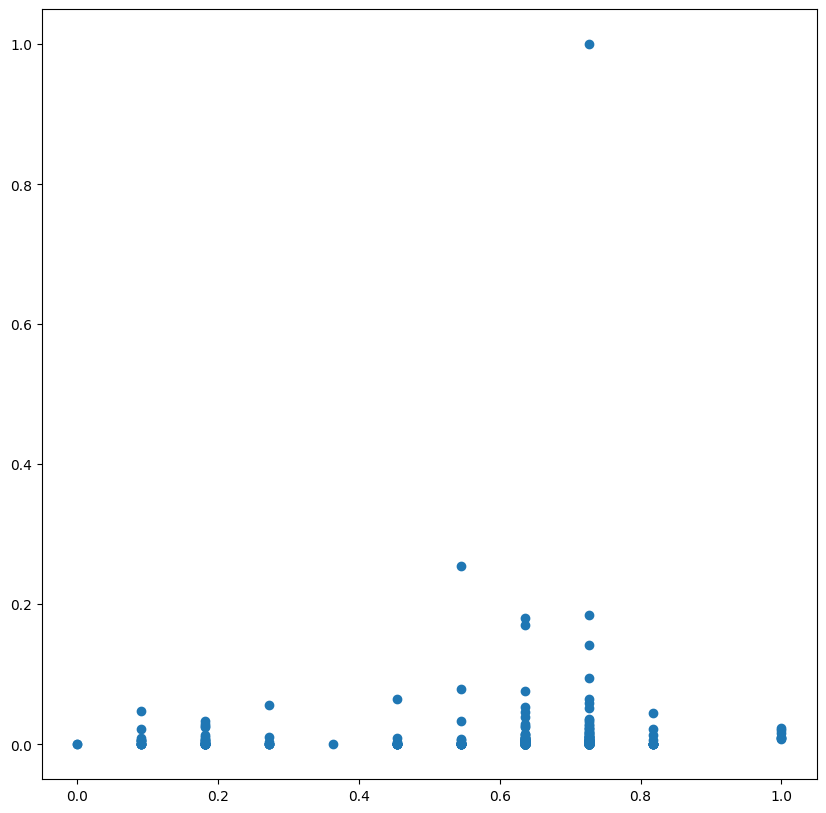

In [13]:
plt.scatter(train[["month"]].to_numpy(),Y_train)

# Hipótesis

In [77]:
def h(X, W):    
    result = np.einsum("ijk,ik->j", X.tolist(), W)
    return result

# Termino Regularizador y derivadas **(ridge, lasso, elasticnet, None)**

In [98]:
def Regularizador(W, lambd, regularizer = "ridge", ratio = 0.3):
    if regularizer == "ridge":
        return lambd * np.sum(np.power((W),2)) # l2 norm 

    elif regularizer == "lasso":
        return lambd * np.sum(np.abs((W))) # l1 norm

    elif regularizer == "elasticnet": # sum of proportions of l1 and l2 norm
        return ((ratio) * (lambd * np.sum(np.abs((W))) )) + ((1-ratio) * (lambd * np.sum(np.power((W),2)))) 
    
    elif regularizer == "None":
        return 0

def Reg_Derivadas(W, lambd, regularizer = "ridge", ratio = 0.3):

    C = 0.0000001

    if regularizer == "ridge":
        return 2 * lambd * (W) # l2 derivative

    elif regularizer == "lasso":
        return lambd * ( W / (np.power((np.power(W, 2) + C), 1/2))) # l1 derivative

    elif regularizer == "elasticnet": # sum of proportions of l1 and l2 derivatives
        return ((ratio) * (lambd * ( W / np.power((np.power(W, 2) + C), 1/2))) + ((1-ratio) * (2 * lambd * (W)))) 
    
    elif regularizer == "None":
        return 0

# Función Loss **(ridge, lasso, elasticnet, None)**

In [101]:
def Error(X, W, Y, lambd, regularizer = "ridge", ratio = 0.3):

  features_len = W.shape[0]
  y_pred = h(X, W)
  l2 = np.sum(np.power((Y - y_pred),2)) # l2 norm
  l2 = l2 / (2*len(Y))
  reg = Regularizador(W, lambd, regularizer, ratio)
  l2 = l2 + reg
  
  return l2 + reg 


# Derivadas **(ridge, lasso, elasticnet, None)**

In [80]:
def derivada(X, W, Y, lambd, regularizer = "ridge", ratio = 0.3):   
    
    A = Y - h(X,W)
    dw = np.einsum("ijk,j->ik", (-X).tolist(), A) 
    dw = dw / len(A)

    reg_deriv = (Reg_Derivadas(W, lambd, regularizer, ratio))
    dw = dw + reg_deriv

    return dw

# Update de Variables


In [81]:
def update(W,  dW, alpha):
    W = W - (alpha * dW)
    return W

### Función generica para mostrar barra de progreso

In [82]:
import sys
def print_progress_bar(index, total, label):
    width = 50 
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(width * index / total):{width}s}] {round((100 * index / total),5)}%  {label}")
    sys.stdout.flush()

## Calcular matrices potenciadas

In [95]:
def getPowMatrices(X, X_val, X_train, p_degree):
    features_len = 0
    try:
        features_len = X.shape[1]
    except IndexError:
        features_len = 1

    pows_3d = np.array([])
    pows_3d_val = np.array([])
    pows_3d_train = np.array([])


    for j in range (0, features_len):
        pows = np.array(np.ones(len(X)))
        pows_val = np.array(np.ones(len(X_val)))
        pows_train = np.array(np.ones(len(X_train)))

        for i in range(1,p_degree+1):
            pows = np.column_stack((pows,np.power(X.T[j],i)))
            pows_val = np.column_stack((pows_val,np.power(X_val.T[j],i)))
            pows_train = np.column_stack((pows_train,np.power(X_train.T[j],i)))

            
        if j == 0:
            pows_3d = [pows]
            pows_3d_val = [pows_val]
            pows_3d_train = [pows_train]


        else:
            pows_3d = np.row_stack((pows_3d, [pows]))
            pows_3d_val = np.row_stack((pows_3d_val, [pows_val]))
            pows_3d_train = np.row_stack((pows_3d_train, [pows_train]))

    return pows_3d, pows_3d_val, pows_3d_train, features_len


# Entrenamiento (por numero de de epochs)

In [102]:
# 3D

def train_epochs_3d(X, Y, X_val, Y_val, X_train, Y_train, epochs, alfa, p_degree, lambd, regularizer = "ridge", ratio = 0.3):
    np.random.seed(2001)

    # pre process x values
    X, X_val, X_train, features_len = getPowMatrices(X, X_val, X_train, p_degree)

    W = np.random.rand(features_len, p_degree + 1)

    loss_train = []
    loss_val = []

    for e in range(epochs):
        L_train = 0
        dW = derivada(X, W, Y, lambd, regularizer, ratio)
        W = update(W, dW, alfa)
        L_train = Error(X, W, Y, lambd, regularizer, ratio) 
        L_val = Error(X_val, W, Y_val, lambd, regularizer, ratio) 
        loss_train.append(L_train)
        loss_val.append(L_val)
        print_progress_bar(e, epochs, f"{Style.BRIGHT}TRAINING IN PROGRESS {Style.RESET_ALL}| {Fore.RED}{Style.BRIGHT}last computed training loss:{Style.RESET_ALL} "+str(L_train) + " | "  + f"{Fore.RED}{Style.BRIGHT}• R^2 training:{Style.RESET_ALL}" + str(rsquared(Y, h(X, W))) + f"{Fore.RED}{Style.BRIGHT}• R^2 validation:{Style.RESET_ALL}" + str(rsquared(Y_validation, h(X_val, W))))

    print(f"\nTraining Completed!\n-------------------------------\n")
    return W, loss_train, loss_val, X, X_val, X_train

   

# Graficar Loss por Epoch


In [103]:
def Plot_Loss(epochs, loss, axes1, axes2, label="loss"):    

    # main fig
    axes1.plot(epochs, loss, label=label)
    axes1.set_xlabel('epochs')
    axes1.set_ylabel('loss')
    axes1.set_title("Loss over Iteration")
    axes1.legend(loc="upper right")

    # zoom
    axes2.plot(epochs[-9:], loss[-9:], label=label)
    axes2.set_xlabel('epochs')
    axes2.set_ylabel('loss')
    axes2.set_title('zoomed in last values');
    axes2.annotate('%0.4f' % loss[-1], xy=(1, loss[-1]), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')

# R^2 (Coeficiente de determinación)

In [86]:
def rsquared(Y, Y_estimation):
  return 1 - (np.sum(np.power(Y - Y_estimation, 2) / np.sum(np.power(Y - np.mean(Y),2))))

# Entrenar y mostrar resultados


In [93]:
def train_output_print(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, alfa, p_degree, lambd, regularizer = "ridge", ratio = 0.3):
    W, loss_train, loss_val, X_train_pow, X_val_pow, X_test_pow = train_epochs_3d(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, alfa, p_degree, lambd, regularizer, ratio)


    print((f"{Fore.GREEN}{Style.BRIGHT}• with epochs:{Style.RESET_ALL}"), epochs, "->", f"{Fore.RED}{Style.BRIGHT}\tlast training loss:{Style.RESET_ALL}",loss_train[-1],f"{Fore.RED}{Style.BRIGHT}\n\t\t\tlast validation loss:{Style.RESET_ALL}",loss_val[-1])
    print(f"{Fore.GREEN}{Style.BRIGHT}\t\t\tmin training loss:{Style.RESET_ALL}", min(loss_train))
    # print(f"{Fore.GREEN}{Style.BRIGHT}• W array:\n{Style.RESET_ALL}", W)

    fig = plt.figure()
    axes1 = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
    axes2 = fig.add_axes([0.5, 0.5, 0.4, 0.3]) # zoom axes

    Plot_Loss(range(len(loss_train)),loss_train, axes1, axes2, "train")
    Plot_Loss(range(len(loss_val)),loss_val, axes1, axes2, "validation")
    r2_train = rsquared(Y_train, h(X_train_pow, W))
    r2_val = rsquared(Y_validation, h(X_val_pow, W))

    print(f"{Fore.RED}{Style.BRIGHT}• R^2 training:{Style.RESET_ALL}",r2_train)
    print(f"{Fore.RED}{Style.BRIGHT}• R^2 validation:{Style.RESET_ALL}",r2_val)

    return W, loss_train, loss_val, X_test_pow, r2_train, r2_val

In [90]:
def test_output_print(X_test, model_W, Y_test, lambd, regularizer, ratio):
    loss_test = Error(X_test, model_W, Y_test, lambd, regularizer, ratio)
    print(f"{Fore.GREEN}{Style.BRIGHT}• test loss on current model:\n{Style.RESET_ALL}", loss_test)
    r2_test = rsquared(Y_test, h(X_test, model_W))
    print(f"{Fore.RED}{Style.BRIGHT}• R^2 test:{Style.RESET_ALL}",r2_test)
    return loss_test, r2_test

# Prueba hiperparámetros ridge

In [91]:
df = pd.DataFrame(columns=["regularizer","lambd","alfa","epochs","p_degree","ratio", "loss_train", "loss_val", "loss_test", "r2_train", "r2_val", "r2_test"])
for r in ["ridge"]:
  for e in [100, 1000, 5000]:
    for l in [0.001, 0.01, 0.1, 1, 5]:
      for a in [0.1, 0.01, 0.001, 0.0001]:
        for p in [1,2,4,6,8,10,20]:
          if r == "elasticnet":

            for ra in [0.3, 0.5, 0.7, 0.9]:
              print("---\nregularizer:",r,"lambd:",l,"alfa:",a,"epochs:",e,"p_degree:", p, "ratio:", ra)

              epochs = e 
              alfa = a 
              p_degree = p 
              lambd = l 
              regularizer = r 
              ratio = ra
              W, loss_train, loss_val, X_test_pow, r2_train, r2_val = train_output_print(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, alfa, p_degree, lambd, regularizer, ratio)
              loss_test, r2_test = test_output_print(X_test_pow, W, Y_test, lambd, regularizer, ratio)

              df = df.append({"regularizer":r,"lambd":l,"alfa":a,"epochs":e,"p_degree":p,"ratio":ra, "loss_train":loss_train[-1], "loss_val":loss_val[-1], "loss_test":loss_test, "r2_train":r2_train, "r2_val":r2_val, "r2_test":r2_test}, ignore_index=True)
          else:
            print("---\nregularizer:",r,"lambd:",l,"alfa:",a,"epochs:",e,"p_degree:",p)
            epochs = e 
            alfa = a 
            p_degree = p 
            lambd = l 
            regularizer = r 
            ratio = 0.3 
            W, loss_train, loss_val, X_test_pow, r2_train, r2_val = train_output_print(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, alfa, p_degree, lambd, regularizer, ratio)
            loss_test, r2_test = test_output_print(X_test_pow, W, Y_test, lambd, regularizer, ratio)
            df = df.append({"regularizer":r,"lambd":l,"alfa":a,"epochs":e,"p_degree":p,"ratio":0, "loss_train":loss_train[-1], "loss_val":loss_val[-1], "loss_test":loss_test, "r2_train":r2_train, "r2_val":r2_val, "r2_test":r2_test}, ignore_index=True)

df.to_csv("ridge_tests.csv")
df

---
regularizer: ridge lambd: 0.001 alfa: 0.1 epochs: 100 p_degree: 1

Training Completed!
-------------------------------

• with epochs: 100 -> 	last training loss: 0.01721751436441252 
			last validation loss: 0.0166294954092469
			min training loss: 0.01721751436441252
• R^2 training: -6.484120170202477
• R^2 validation: -99.94153861382466
• test loss on current model:
 0.07147832191253066
• R^2 test: -18.456585536772398
---
regularizer: ridge lambd: 0.001 alfa: 0.1 epochs: 100 p_degree: 2

Training Completed!
-------------------------------

• with epochs: 100 -> 	last training loss: 0.020167933297146185 
			last validation loss: 0.016885842770205755
			min training loss: 0.020167933297146185
• R^2 training: -6.974880872626694
• R^2 validation: -83.93316372552356
• test loss on current model:
 1.0244065664218949
• R^2 test: -295.82606409226673
---
regularizer: ridge lambd: 0.001 alfa: 0.1 epochs: 100 p_degree: 4

Training Completed!
-------------------------------

• with epochs: 

<ipython-input-79-4bddb9028ed6>:12: RuntimeWarning: overflow encountered in power
  l2 = np.sum(np.power((Y - y_pred),2)) # l2 norm
<ipython-input-86-197391f0b7ea>:2: RuntimeWarning: overflow encountered in power
  return 1 - (np.sum(np.power(Y - Y_estimation, 2) / np.sum(np.power(Y - np.mean(Y),2))))



Training Completed!
-------------------------------

• with epochs: 1000 -> 	last training loss: 0.010940506664432186 
			last validation loss: 0.009462015816272012
			min training loss: 0.010940506664432186
• R^2 training: -0.120881743564627
• R^2 validation: -2.2700857641105014
• test loss on current model:
 0.013488104478255089
• R^2 test: -0.286463058419826
---
regularizer: ridge lambd: 0.1 alfa: 0.01 epochs: 1000 p_degree: 2

Training Completed!
-------------------------------

• with epochs: 1000 -> 	last training loss: 0.015013170920494404 
			last validation loss: 0.013470777542125074
			min training loss: 0.015013170920494404
• R^2 training: -0.12530402793950568
• R^2 validation: -1.7881818371599643
• test loss on current model:
 0.03551866249144926
• R^2 test: -5.527360455075228
---
regularizer: ridge lambd: 0.1 alfa: 0.01 epochs: 1000 p_degree: 4

Training Completed!
-------------------------------

• with epochs: 1000 -> 	last training loss: 0.020451161997435158 
			last v

c:\Users\mauri\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-78-3c36073289a9>:3: RuntimeWarning: overflow encountered in power
  return lambd * np.sum(np.power((W),2)) # l2 norm



Training Completed!
-------------------------------

• with epochs: 1000 -> 	last training loss: inf 
			last validation loss: inf
			min training loss: 669.7828300922861
• R^2 training: -inf
• R^2 validation: -inf
• test loss on current model:
 inf
• R^2 test: -inf
---
regularizer: ridge lambd: 1 alfa: 0.01 epochs: 1000 p_degree: 1

Training Completed!
-------------------------------

• with epochs: 1000 -> 	last training loss: 0.0016742826213720155 
			last validation loss: 0.00013724227247349685
			min training loss: 0.0016742826175260878
• R^2 training: 0.001891876790281688
• R^2 validation: -0.03309373930650095
• test loss on current model:
 0.0034667747201737368
• R^2 test: -0.0066746826256440794
---
regularizer: ridge lambd: 1 alfa: 0.01 epochs: 1000 p_degree: 2

Training Completed!
-------------------------------

• with epochs: 1000 -> 	last training loss: 0.0016721877162258138 
			last validation loss: 0.00013812766167303422
			min training loss: 0.0016721877162258138
• R^2 

<ipython-input-78-3c36073289a9>:3: RuntimeWarning: overflow encountered in double_scalars
  return lambd * np.sum(np.power((W),2)) # l2 norm



Training Completed!
-------------------------------

• with epochs: 1000 -> 	last training loss: inf 
			last validation loss: inf
			min training loss: 197.5298300184213
• R^2 training: -inf
• R^2 validation: -inf
• test loss on current model:
 inf
• R^2 test: -inf
---
regularizer: ridge lambd: 5 alfa: 0.1 epochs: 1000 p_degree: 2

Training Completed!
-------------------------------

• with epochs: 1000 -> 	last training loss: inf 
			last validation loss: inf
			min training loss: 326.51302084275943
• R^2 training: -inf
• R^2 validation: -inf
• test loss on current model:
 inf
• R^2 test: -inf
---
regularizer: ridge lambd: 5 alfa: 0.1 epochs: 1000 p_degree: 4

Training Completed!
-------------------------------

• with epochs: 1000 -> 	last training loss: inf 
			last validation loss: inf
			min training loss: 509.4150341740111
• R^2 training: -inf
• R^2 validation: -inf
• test loss on current model:
 inf
• R^2 test: -inf
---
regularizer: ridge lambd: 5 alfa: 0.1 epochs: 1000 p_degr

<ipython-input-81-bff8601229f3>:2: RuntimeWarning: invalid value encountered in subtract
  W = W - (alpha * dW)



Training Completed!
-------------------------------

• with epochs: 1000 -> 	last training loss: nan 
			last validation loss: nan
			min training loss: 660.6287779657496
• R^2 training: nan
• R^2 validation: nan
• test loss on current model:
 nan
• R^2 test: nan
---
regularizer: ridge lambd: 5 alfa: 0.1 epochs: 1000 p_degree: 10

Training Completed!
-------------------------------

• with epochs: 1000 -> 	last training loss: nan 
			last validation loss: nan
			min training loss: 1392.5917631791867
• R^2 training: nan
• R^2 validation: nan
• test loss on current model:
 nan
• R^2 test: nan
---
regularizer: ridge lambd: 5 alfa: 0.1 epochs: 1000 p_degree: 20

Training Completed!
-------------------------------

• with epochs: 1000 -> 	last training loss: nan 
			last validation loss: nan
			min training loss: 2104.623721861175
• R^2 training: nan
• R^2 validation: nan
• test loss on current model:
 nan
• R^2 test: nan
---
regularizer: ridge lambd: 5 alfa: 0.01 epochs: 1000 p_degree: 1


KeyboardInterrupt: 

# Ridge testing


Training Completed!
-------------------------------

• with epochs: 5000 -> 	last training loss: 0.001642864968525087 
			last validation loss: 0.00015589948037220974
			min training loss: 0.0016428601826492446
• R^2 training: 0.019010971285576495
• R^2 validation: -0.21742528873997036
• test loss on current model:
 0.003398320189188791
• R^2 test: 0.01242712545962632


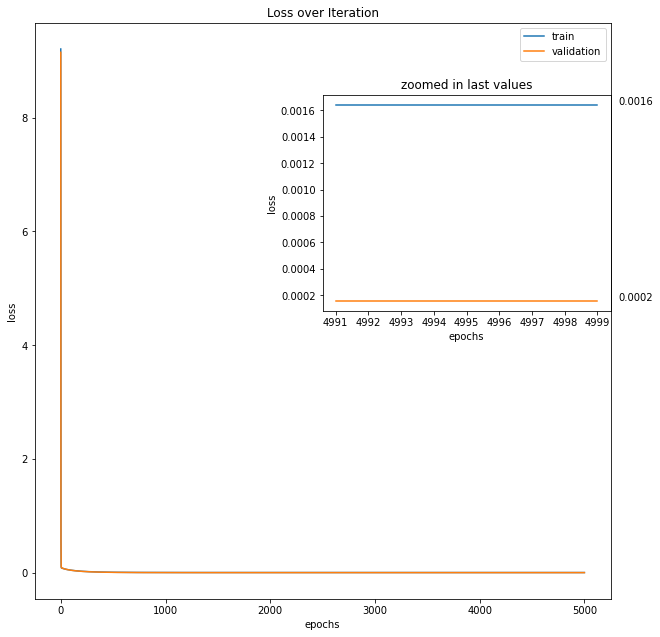

In [94]:
epochs = 5000
alfa = 0.1
p_degree = 1
lambd = 0.01
regularizer = "ridge"
ratio = 0

W, loss_train, loss_val, X_test_pow, r2_train, r2_val = train_output_print(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, alfa, p_degree, lambd, regularizer, ratio)
loss_test, r2_test = test_output_print(X_test_pow, W, Y_test, lambd, regularizer, ratio)

# Prueba hiperparámetros lasso

In [ ]:
df = pd.DataFrame(columns=["regularizer","lambd","alfa","epochs","p_degree","ratio", "loss_train", "loss_val", "loss_test", "r2_train", "r2_val", "r2_test"])
for r in ["lasso"]:
  for e in [100, 1000, 5000]:
    for l in [0.001, 0.01, 0.1, 1, 5]:
      for a in [0.1, 0.01, 0.001, 0.0001]:
        for p in [1,2,4,6,8,10,20]:
          if r == "elasticnet":

            for ra in [0.3, 0.5, 0.7, 0.9]:
              print("---\nregularizer:",r,"lambd:",l,"alfa:",a,"epochs:",e,"p_degree:", p, "ratio:", ra)

              epochs = e 
              alfa = a 
              p_degree = p 
              lambd = l 
              regularizer = r
              ratio = ra
              W, loss_train, loss_val, X_test_pow, r2_train, r2_val = train_output_print(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, alfa, p_degree, lambd, regularizer, ratio)
              loss_test, r2_test = test_output_print(X_test_pow, W, Y_test, lambd, regularizer, ratio)

              df = df.append({"regularizer":r,"lambd":l,"alfa":a,"epochs":e,"p_degree":p,"ratio":ra, "loss_train":loss_train[-1], "loss_val":loss_val[-1], "loss_test":loss_test, "r2_train":r2_train, "r2_val":r2_val, "r2_test":r2_test}, ignore_index=True)
          else:
            print("---\nregularizer:",r,"lambd:",l,"alfa:",a,"epochs:",e,"p_degree:",p)
            epochs = e 
            alfa = a 
            p_degree = p 
            lambd = l 
            regularizer = r 
            ratio = 0.3 
            W, loss_train, loss_val, X_test_pow, r2_train, r2_val = train_output_print(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, alfa, p_degree, lambd, regularizer, ratio)
            loss_test, r2_test = test_output_print(X_test_pow, W, Y_test, lambd, regularizer, ratio)
            df = df.append({"regularizer":r,"lambd":l,"alfa":a,"epochs":e,"p_degree":p,"ratio":0, "loss_train":loss_train[-1], "loss_val":loss_val[-1], "loss_test":loss_test, "r2_train":r2_train, "r2_val":r2_val, "r2_test":r2_test}, ignore_index=True)

df.to_csv("lasso_tests.csv")
df

# Lasso testing

In [ ]:
epochs = 5000
alfa = 0.1
p_degree = 1
lambd = 0.001
regularizer = "lasso"
ratio = 0

W, loss_train, loss_val, X_test_pow, r2_train, r2_val = train_output_print(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, alfa, p_degree, lambd, regularizer, ratio)
loss_test, r2_test = test_output_print(X_test_pow, W, Y_test, lambd, regularizer, ratio)

# Prueba hiperparámetros elasticnet


In [ ]:
df = pd.DataFrame(columns=["regularizer","lambd","alfa","epochs","p_degree","ratio", "loss_train", "loss_val", "loss_test", "r2_train", "r2_val", "r2_test"])
for r in ["elasticnet"]:
  for e in [100, 1000, 5000]:
    for l in [0.001, 0.01, 0.1, 1, 5]:
      for a in [0.1, 0.01, 0.001, 0.0001]:
        for p in [1,2,4,6,8,10,20]:
          if r == "elasticnet":
            for ra in [0.3, 0.5, 0.7, 0.9]:
              print("---\nregularizer:",r,"lambd:",l,"alfa:",a,"epochs:",e,"p_degree:", p, "ratio:", ra)

              epochs = e 
              alfa = a 
              p_degree = p 
              lambd = l 
              regularizer = r 
              ratio = ra
              W, loss_train, loss_val, X_test_pow, r2_train, r2_val = train_output_print(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, alfa, p_degree, lambd, regularizer, ratio)
              loss_test, r2_test = test_output_print(X_test_pow, W, Y_test, lambd, regularizer, ratio)

              df = df.append({"regularizer":r,"lambd":l,"alfa":a,"epochs":e,"p_degree":p,"ratio":ra, "loss_train":loss_train[-1], "loss_val":loss_val[-1], "loss_test":loss_test, "r2_train":r2_train, "r2_val":r2_val, "r2_test":r2_test}, ignore_index=True)
          else:
            print("---\nregularizer:",r,"lambd:",l,"alfa:",a,"epochs:",e,"p_degree:",p)
            epochs = e 
            alfa = a 
            p_degree = p 
            lambd = l 
            regularizer = r 
            ratio = 0.3 
            W, loss_train, loss_val, X_test_pow, r2_train, r2_val = train_output_print(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, alfa, p_degree, lambd, regularizer, ratio)
            loss_test, r2_test = test_output_print(X_test_pow, W, Y_test, lambd, regularizer, ratio)
            df = df.append({"regularizer":r,"lambd":l,"alfa":a,"epochs":e,"p_degree":p,"ratio":0, "loss_train":loss_train[-1], "loss_val":loss_val[-1], "loss_test":loss_test, "r2_train":r2_train, "r2_val":r2_val, "r2_test":r2_test}, ignore_index=True)

df.to_csv("elasticnet_tests.csv")
df

# Elasticnet testing

In [ ]:
epochs = 1000
alfa = 0.01
p_degree = 6
lambd = 5
regularizer = "elasticnet"
ratio = 0.9

W, loss_train, loss_val, X_test_pow, r2_train, r2_val = train_output_print(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, alfa, p_degree, lambd, regularizer, ratio)

loss_test, r2_test = test_output_print(X_test_pow, W, Y_test, lambd, regularizer, ratio)

# Prueba hiperparámetros sin regularizacion

In [ ]:
df = pd.DataFrame(columns=["regularizer","lambd","alfa","epochs","p_degree","ratio", "loss_train", "loss_val", "loss_test", "r2_train", "r2_val", "r2_test"])
for r in ["None"]:
  for e in [100, 1000, 5000]:
    for l in [0.001, 0.01, 0.1, 1, 5]:
      for a in [0.1, 0.01, 0.001, 0.0001]:
        for p in [1,2,4,6,8,10,20]:
          if r == "elasticnet":

            for ra in [0.3, 0.5, 0.7, 0.9]:
              print("---\nregularizer:",r,"lambd:",l,"alfa:",a,"epochs:",e,"p_degree:", p, "ratio:", ra)

              epochs = e 
              alfa = a 
              p_degree = p 
              lambd = l 
              regularizer = r 
              ratio = ra
              W, loss_train, loss_val, X_test_pow, r2_train, r2_val = train_output_print(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, alfa, p_degree, lambd, regularizer, ratio)
              loss_test, r2_test = test_output_print(X_test_pow, W, Y_test, lambd, regularizer, ratio)

              df = df.append({"regularizer":r,"lambd":l,"alfa":a,"epochs":e,"p_degree":p,"ratio":ra, "loss_train":loss_train[-1], "loss_val":loss_val[-1], "loss_test":loss_test, "r2_train":r2_train, "r2_val":r2_val, "r2_test":r2_test}, ignore_index=True)
          else:
            print("---\nregularizer:",r,"lambd:",l,"alfa:",a,"epochs:",e,"p_degree:",p)
            epochs = e 
            alfa = a 
            p_degree = p 
            lambd = l 
            regularizer = r 
            ratio = 0.3 
            W, loss_train, loss_val, X_test_pow, r2_train, r2_val = train_output_print(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, alfa, p_degree, lambd, regularizer, ratio)
            loss_test, r2_test = test_output_print(X_test_pow, W, Y_test, lambd, regularizer, ratio)
            df = df.append({"regularizer":r,"lambd":l,"alfa":a,"epochs":e,"p_degree":p,"ratio":0, "loss_train":loss_train[-1], "loss_val":loss_val[-1], "loss_test":loss_test, "r2_train":r2_train, "r2_val":r2_val, "r2_test":r2_test}, ignore_index=True)

df.to_csv("no_regularization_tests.csv")
df

# Sin regularizacion testing

In [ ]:
epochs = 5000
alfa = 0.1
p_degree = 1
lambd = 0.001
regularizer = "None"
ratio = 0

W, loss_train, loss_val, X_test_pow, r2_train, r2_val = train_output_print(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, alfa, p_degree, lambd, regularizer, ratio)
loss_test, r2_test = test_output_print(X_test_pow, W, Y_test, lambd, regularizer, ratio)